In [391]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 3)

In [590]:
def csv2df(csvfile, i):
    print csvfile
    df = pd.read_csv(csvfile, sep=',')
    df = df.astype(str) 
    #delete any data point that have 2 blanks for now - these are absent students
    df = df[(df['q1']!='BLANK') & (df['q2']!='BLANK')]
    suffix = ['_a' + str(i+1) for j in range(df.shape[1]-1)]
    newNames = df.columns[1:]+suffix
    df.rename(columns = dict(zip(df.columns[1:], newNames)), inplace = True)
    return df

In [591]:
dfs = {}
wd = 'data/'
csvfiles = [wd+'act' + str(i) + '-post.csv' for i in np.arange(5)+1]
for i, csvfile in enumerate(csvfiles):
    dfs[i+1] = csv2df(csvfile, i)

data/act1-post.csv
data/act2-post.csv
data/act3-post.csv
data/act4-post.csv
data/act5-post.csv


In [592]:
attendance = [len(dfs[i]) for i in dfs.keys()]
print attendance

[262, 241, 259, 229, 243]


In [593]:
#merge dataframes on student id for self-report questions
# sra = pd.merge(dfs[2], dfs[3], how='outer', left_on=['student id_a2'], right_on=['student id_a3'])
# srb = pd.merge(dfs[4], dfs[5], how='outer', left_on=['student id_a4'], right_on=['student id_a5'])
sra = pd.merge(dfs[1], dfs[2], how='outer', on=['student id'])
srb = pd.merge(dfs[3], dfs[4], how='outer', on=['student id'])
src = pd.merge(sra, srb, how='outer', on=['student id'])
srd = pd.merge(src, dfs[5], how='outer', on=['student id'])

In [594]:
srd.shape

(318, 34)

In [595]:
def findCondition(row):
    section = row['Section'].split()[-1][-1]
    if section in cond2sect['SIM']:
        return 'SIM'
    elif section in cond2sect['DATA']:
        return 'DATA'
    else:
        error('section not found')

df1 = pd.read_csv(wd+'subjects.csv', sep=',')
cond2sect = {'SIM':'B D E H J'.split(),'DATA':'A C F G I'.split()};
df1['Condition'] = df1.apply(lambda row: findCondition(row), axis=1)
df1 = df1[['SIS User ID', 'Condition']]
df1 = df1.astype(str) 
sr = pd.merge(srd, df1, how='outer', left_on=['student id'], right_on=['SIS User ID'])

print df1.shape
print sr.shape
#for now ignore student ID errors that do not match Canvas record
sr = sr[~sr['SIS User ID'].isnull()]
sr = sr[~sr['student id'].isnull()]
print sr.shape

(318, 2)
(334, 36)
(305, 36)


Answer          SD         D         N         A        SA
Activity                                                  
q1_a1     0.022901  0.106870  0.385496  0.427481  0.057252
q1_a2     0.021459  0.047210  0.274678  0.476395  0.180258
q1_a3     0.003861  0.030888  0.293436  0.544402  0.127413
q1_a4     0.021645  0.116883  0.376623  0.389610  0.095238
q1_a5     0.036585  0.093496  0.406504  0.369919  0.093496


(1, 5)

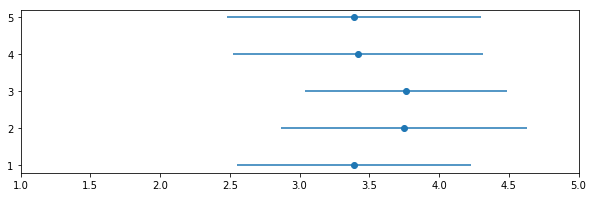

In [685]:
questions1 = ['q1_a1', 'q1_a2','q1_a3','q1_a4','q1_a5']
q1sr = pd.melt(sr, id_vars=['student id'], value_vars=questions1, 
               var_name='Activity', value_name='Answer')
results = q1sr.groupby(['Activity', 'Answer']).size().unstack().fillna(0)
#rename to Likert scale
results.rename(columns = dict(zip(results.columns, ['SA','A','N','D','SD'])), inplace = True)
#reverse so that left is SD and right is SA
results = results.loc[:,::-1]
#normalize to 1 so that can easily compare in diverging stacked histogram
results = results.apply(lambda row: row/row.sum(), axis=1)
print results
#adding offset column for plotting stacked histogram
middles = results[["SD", "D"]].sum(axis=1)+results["N"]*.5
complete_longest = results[:].sum(axis=1)
longest = middles.max()
offset = (middles - longest).abs()
results.insert(0, 'offset', offset)

numerize = dict(zip('A B C D E F'.split(), [5,4,3,2,1,np.NaN]))
#for now set 'blanks' to 0, same with student id mismatch that create NaN entries
q1sr['Answer'] = q1sr['Answer'].fillna('F')
q1sr['answer numeric'] = q1sr.apply(lambda row: numerize[row['Answer']], axis=1)
# print q1sr.loc[q1sr['answer numeric'].isnull(),:]

x = xerr = y = []
for i,question in enumerate(questions1):
    y = y + [i+1]
    x = x + [q1sr.loc[q1sr['Activity']==question,'answer numeric'].mean(skipna=True)]
    xerr = xerr + [q1sr.loc[q1sr['Activity']==question,'answer numeric'].std(skipna=True)]

plt.figure()
plt.errorbar(x, y, xerr=xerr, fmt='o')
plt.xlim((1,5)) 

([<matplotlib.axis.XTick at 0x1a20760410>,
 <a list of 10 Text xticklabel objects>)

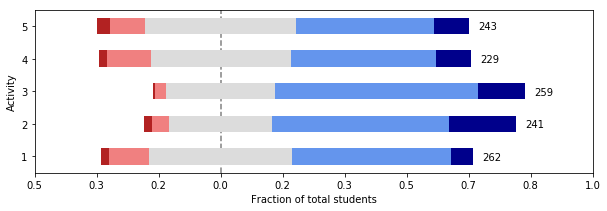

In [686]:
likert_colors = ['white', 'firebrick','lightcoral','gainsboro','cornflowerblue', 'darkblue']
ax = results.plot.barh(stacked=True, color=likert_colors, edgecolor='none', legend=False)
ax2 = plt.axvline(longest, linestyle='--', color='black', alpha=.5)
ax2.set_zorder(-1)

for i, v in enumerate(offset):
    ax.text(v + 1.025, i-0.1, str(attendance[i]), color='k')

ax.set_yticklabels(['1','2','3','4','5'])
plt.xlabel('Fraction of total students')
xvalues1 = np.arange(-longest/2,longest+longest/2,longest/2)
xvalues2 = np.arange(longest,1.4,longest/2)
xvalues = np.append(xvalues1,xvalues2[1:])
xlabels = [str(abs(round(x-longest,1))) for x in xvalues]
plt.xticks(xvalues, xlabels)


Answer          SD         D         N         A        SA
Activity                                                  
q2_a1     0.019084  0.053435  0.278626  0.541985  0.106870
q2_a2     0.017167  0.060086  0.167382  0.527897  0.227468
q2_a3     0.000000  0.011583  0.104247  0.687259  0.196911
q2_a4     0.047619  0.116883  0.251082  0.467532  0.116883
q2_a5     0.060976  0.252033  0.292683  0.308943  0.085366


(1, 5)

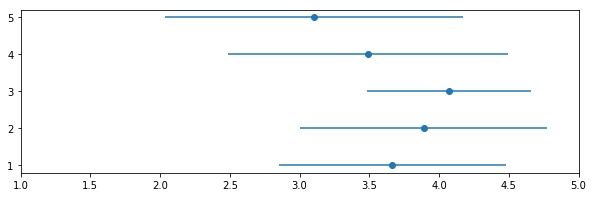

In [672]:
questions2 = ['q2_a1', 'q2_a2','q2_a3','q2_a4','q2_a5']
q1sr = pd.melt(sr, id_vars=['student id'], value_vars=questions2, 
               var_name='Activity', value_name='Answer')
results = q1sr.groupby(['Activity', 'Answer']).size().unstack().fillna(0)
#rename to Likert scale
results.rename(columns = dict(zip(results.columns, ['SA','A','N','D','SD'])), inplace = True)
#reverse so that left is SD and right is SA
results = results.loc[:,::-1]
#normalize to 1 so that can easily compare in diverging stacked histogram
results = results.apply(lambda row: row/row.sum(), axis=1)
print results
#adding offset column for plotting stacked histogram
middles = results[["SD", "D"]].sum(axis=1)+results["N"]*.5
complete_longest = results[:].sum(axis=1)
longest = middles.max()
offset = (middles - longest).abs()
results.insert(0, 'offset', offset)

numerize = dict(zip('A B C D E F'.split(), [5,4,3,2,1,np.NaN]))
#for now set 'blanks' to 0, same with student id mismatch that create NaN entries
q1sr['Answer'] = q1sr['Answer'].fillna('F')
q1sr['answer numeric'] = q1sr.apply(lambda row: numerize[row['Answer']], axis=1)
# print q1sr.loc[q1sr['answer numeric'].isnull(),:]

x = xerr = y = []
for i,question in enumerate(questions2):
    y = y + [i+1]
    x = x + [q1sr.loc[q1sr['Activity']==question,'answer numeric'].mean(skipna=True)]
    xerr = xerr + [q1sr.loc[q1sr['Activity']==question,'answer numeric'].std(skipna=True)]

plt.figure()
plt.errorbar(x, y, xerr=xerr, fmt='o')
plt.xlim((1,5)) 

([<matplotlib.axis.XTick at 0x1a217d68d0>,
 <a list of 9 Text xticklabel objects>)

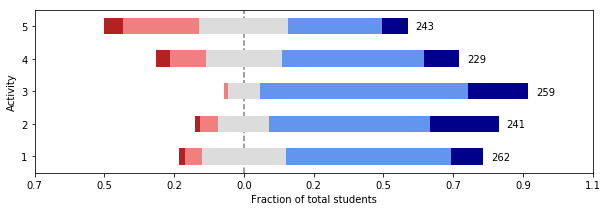

In [525]:
likert_colors = ['white', 'firebrick','lightcoral','gainsboro','cornflowerblue', 'darkblue']
ax = results.plot.barh(stacked=True, color=likert_colors, edgecolor='none', legend=False)
ax2 = plt.axvline(longest, linestyle='--', color='black', alpha=.5)
ax2.set_zorder(-1)

for i, v in enumerate(offset):
    ax.text(v + 1.025, i-0.1, str(attendance[i]), color='k')

ax.set_yticklabels(['1','2','3','4','5'])
plt.xlabel('Fraction of total students')
xvalues1 = np.arange(-longest/2,longest+longest/2,longest/2)
xvalues2 = np.arange(longest,1.7,longest/2)
xvalues = np.append(xvalues1,xvalues2[1:])
xlabels = [str(abs(round(x-longest,1))) for x in xvalues]
plt.xticks(xvalues, xlabels)


### Per conditions

([<matplotlib.axis.XTick at 0x1a232b0250>,
 <a list of 11 Text xticklabel objects>)

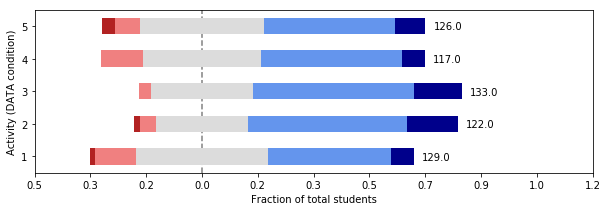

In [677]:
q1srD = pd.melt(sr[sr['Condition']=='DATA'], id_vars=['student id'], value_vars=questions1, 
               var_name='Activity (DATA condition)', value_name='Answer')
results = q1srD.groupby(['Activity (DATA condition)', 'Answer']).size().unstack().fillna(0)
#rename to Likert scale
results.rename(columns = dict(zip(results.columns, ['SA','A','N','D','SD'])), inplace = True)
#reverse so that left is SD and right is SA
results = results.loc[:,::-1]
#normalize to 1 so that can easily compare in diverging stacked histogram
attendance_condition = results.sum(axis=1)
results = results.apply(lambda row: row/row.sum(), axis=1)
#adding offset column for plotting stacked histogram
middles = results[["SD", "D"]].sum(axis=1)+results["N"]*.5
complete_longest = results[:].sum(axis=1)
longest = middles.max()
offset = (middles - longest).abs()
results.insert(0, 'offset', offset)
ax = results.plot.barh(stacked=True, color=likert_colors, edgecolor='none', legend=False)
ax2 = plt.axvline(longest, linestyle='--', color='black', alpha=.5)
ax2.set_zorder(-1)

for i, v in enumerate(offset):
    ax.text(v + 1.025, i-0.1, str(attendance_condition[i]), color='k')

ax.set_yticklabels(['1','2','3','4','5'])
plt.xlabel('Fraction of total students')
xvalues1 = np.arange(-longest/2,longest+longest/2,longest/2)
xvalues2 = np.arange(longest,1.7,longest/2)
xvalues = np.append(xvalues1,xvalues2[1:])
xlabels = [str(abs(round(x-longest,1))) for x in xvalues]
plt.xticks(xvalues, xlabels)

([<matplotlib.axis.XTick at 0x1a221de2d0>,
 <a list of 11 Text xticklabel objects>)

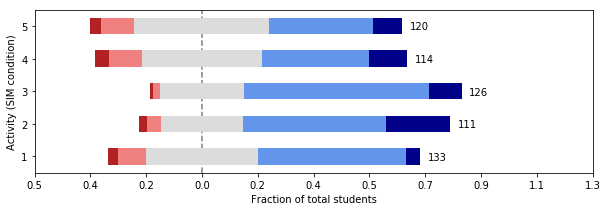

In [678]:
q1srS = pd.melt(sr[sr['Condition']=='SIM'], id_vars=['student id'], value_vars=questions1, 
               var_name='Activity (SIM condition)', value_name='Answer')
results = q1srS.groupby(['Activity (SIM condition)', 'Answer']).size().unstack().fillna(0)
#rename to Likert scale
results.rename(columns = dict(zip(results.columns, ['SA','A','N','D','SD'])), inplace = True)
#reverse so that left is SD and right is SA
results = results.loc[:,::-1]
#normalize to 1 so that can easily compare in diverging stacked histogram
attendance_condition = results.sum(axis=1)
results = results.apply(lambda row: row/row.sum(), axis=1)
#adding offset column for plotting stacked histogram
middles = results[["SD", "D"]].sum(axis=1)+results["N"]*.5
complete_longest = results[:].sum(axis=1)
longest = middles.max()
offset = (middles - longest).abs()
results.insert(0, 'offset', offset)
ax = results.plot.barh(stacked=True, color=likert_colors, edgecolor='none', legend=False)
ax2 = plt.axvline(longest, linestyle='--', color='black', alpha=.5)
ax2.set_zorder(-1)

for i, v in enumerate(offset):
    ax.text(v + 1.025, i-0.1, str(attendance_condition[i]), color='k')

ax.set_yticklabels(['1','2','3','4','5'])
plt.xlabel('Fraction of total students')
xvalues1 = np.arange(-longest/2,longest+longest/2,longest/2)
xvalues2 = np.arange(longest,1.7,longest/2)
xvalues = np.append(xvalues1,xvalues2[1:])
xlabels = [str(abs(round(x-longest,1))) for x in xvalues]
plt.xticks(xvalues, xlabels)

In [679]:
q1srS['Answer'] = q1srS['Answer'].fillna('F')
q1srS['answer numeric'] = q1srS.apply(lambda row: numerize[row['Answer']], axis=1)
# print q1sr.loc[q1sr['answer numeric'].isnull(),:]

xS = xerrS = yS = []
for i,question in enumerate(questions1):
    yS = yS + [i+1]
    xS = xS + [q1srS.loc[q1srS['Activity (SIM condition)']==question,'answer numeric'].mean(skipna=True)]
    xerrS = xerrS + [q1srS.loc[q1srS['Activity (SIM condition)']==question,'answer numeric'].std(skipna=True)]



(1, 5)

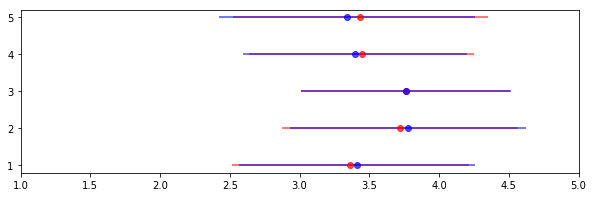

In [680]:
q1srD['Answer'] = q1srD['Answer'].fillna('F')
q1srD['answer numeric'] = q1srD.apply(lambda row: numerize[row['Answer']], axis=1)
# print q1sr.loc[q1sr['answer numeric'].isnull(),:]

xD = xerrD = yD = []
for i,question in enumerate(questions1):
    yD = yD + [i+1]
    xD = xD + [q1srD.loc[q1srD['Activity (DATA condition)']==question,'answer numeric'].mean(skipna=True)]
    xerrD = xerrD + [q1srD.loc[q1srD['Activity (DATA condition)']==question,'answer numeric'].std(skipna=True)]

plt.figure()
plt.errorbar(xD, yD, xerr=xerrD, fmt='ro', alpha=0.7)
plt.errorbar(xS, yS, xerr=xerrD, fmt='bo', alpha=0.7)
plt.xlim((1,5)) 

([<matplotlib.axis.XTick at 0x1a222968d0>,
 <a list of 10 Text xticklabel objects>)

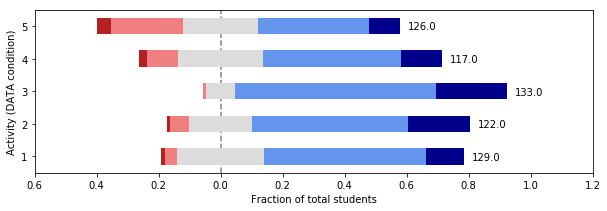

In [681]:
q1srD = pd.melt(sr[sr['Condition']=='DATA'], id_vars=['student id'], value_vars=questions2, 
               var_name='Activity (DATA condition)', value_name='Answer')
results = q1srD.groupby(['Activity (DATA condition)', 'Answer']).size().unstack().fillna(0)
#rename to Likert scale
results.rename(columns = dict(zip(results.columns, ['SA','A','N','D','SD'])), inplace = True)
#reverse so that left is SD and right is SA
results = results.loc[:,::-1]
#normalize to 1 so that can easily compare in diverging stacked histogram
attendance_condition = results.sum(axis=1)
results = results.apply(lambda row: row/row.sum(), axis=1)
#adding offset column for plotting stacked histogram
middles = results[["SD", "D"]].sum(axis=1)+results["N"]*.5
complete_longest = results[:].sum(axis=1)
longest = middles.max()
offset = (middles - longest).abs()
results.insert(0, 'offset', offset)
ax = results.plot.barh(stacked=True, color=likert_colors, edgecolor='none', legend=False)
ax2 = plt.axvline(longest, linestyle='--', color='black', alpha=.5)
ax2.set_zorder(-1)

for i, v in enumerate(offset):
    ax.text(v + 1.025, i-0.1, str(attendance_condition[i]), color='k')

ax.set_yticklabels(['1','2','3','4','5'])
plt.xlabel('Fraction of total students')
xvalues1 = np.arange(-longest/2,longest+longest/2,longest/2)
xvalues2 = np.arange(longest,1.7,longest/2)
xvalues = np.append(xvalues1,xvalues2[1:])
xlabels = [str(abs(round(x-longest,1))) for x in xvalues]
plt.xticks(xvalues, xlabels)

([<matplotlib.axis.XTick at 0x1a1f057350>,
 <a list of 8 Text xticklabel objects>)

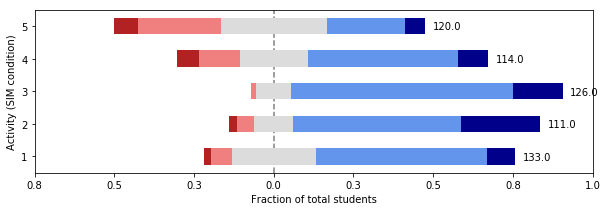

In [682]:
q1srS = pd.melt(sr[sr['Condition']=='SIM'], id_vars=['student id'], value_vars=questions2, 
               var_name='Activity (SIM condition)', value_name='Answer')
results = q1srS.groupby(['Activity (SIM condition)', 'Answer']).size().unstack().fillna(0)
#rename to Likert scale
results.rename(columns = dict(zip(results.columns, ['SA','A','N','D','SD'])), inplace = True)
#reverse so that left is SD and right is SA
results = results.loc[:,::-1]
#normalize to 1 so that can easily compare in diverging stacked histogram
attendance_condition = results.sum(axis=1)
results = results.apply(lambda row: row/row.sum(), axis=1)
#adding offset column for plotting stacked histogram
middles = results[["SD", "D"]].sum(axis=1)+results["N"]*.5
complete_longest = results[:].sum(axis=1)
longest = middles.max()
offset = (middles - longest).abs()
results.insert(0, 'offset', offset)
ax = results.plot.barh(stacked=True, color=likert_colors, edgecolor='none', legend=False)
ax2 = plt.axvline(longest, linestyle='--', color='black', alpha=.5)
ax2.set_zorder(-1)

for i, v in enumerate(offset):
    ax.text(v + 1.025, i-0.1, str(attendance_condition[i]), color='k')

ax.set_yticklabels(['1','2','3','4','5'])
plt.xlabel('Fraction of total students')
xvalues1 = np.arange(-longest/2,longest+longest/2,longest/2)
xvalues2 = np.arange(longest,1.7,longest/2)
xvalues = np.append(xvalues1,xvalues2[1:])
xlabels = [str(abs(round(x-longest,1))) for x in xvalues]
plt.xticks(xvalues, xlabels)

In [683]:
q1srS['Answer'] = q1srS['Answer'].fillna('F')
q1srS['answer numeric'] = q1srS.apply(lambda row: numerize[row['Answer']], axis=1)
# print q1sr.loc[q1sr['answer numeric'].isnull(),:]

xS = xerrS = yS = []
for i,question in enumerate(questions2):
    yS = yS + [i+1]
    xS = xS + [q1srS.loc[q1srS['Activity (SIM condition)']==question,'answer numeric'].mean(skipna=True)]
    xerrS = xerrS + [q1srS.loc[q1srS['Activity (SIM condition)']==question,'answer numeric'].std(skipna=True)]
    

(1, 5)

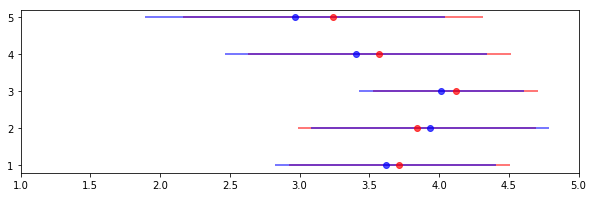

In [684]:
q1srD['Answer'] = q1srD['Answer'].fillna('F')
q1srD['answer numeric'] = q1srD.apply(lambda row: numerize[row['Answer']], axis=1)
# print q1sr.loc[q1sr['answer numeric'].isnull(),:]

xD = xerrD = yD = []
for i,question in enumerate(questions2):
    yD = yD + [i+1]
    xD = xD + [q1srD.loc[q1srD['Activity (DATA condition)']==question,'answer numeric'].mean(skipna=True)]
    xerrD = xerrD + [q1srD.loc[q1srD['Activity (DATA condition)']==question,'answer numeric'].std(skipna=True)]

plt.figure()
plt.errorbar(xD, yD, xerr=xerrD, fmt='ro', alpha=0.7)
plt.errorbar(xS, yS, xerr=xerrD, fmt='bo', alpha=0.7)
plt.xlim((1,5)) 